# Multi-Scenario MORDM

Multi-scenario MORMD is an extension of normal MORDM to better include robustness considerations within the search phase. It starts from the scenario discovery results resulting from MORDM. Next, from the experiments within this box, a set of scenarios is selected. 

There are many ways of selecting the additional scenarios. The original paper which introduced multi-scenario MORMD [Watson and Kaspzryk (2017)](https://doi.org/10.1016/j.envsoft.2016.12.001) did it in a more or less adhoc manner. [Eker and Kwakkel (2018)](https://doi.org/10.1016/j.envsoft.2018.03.029) introduced a more formal selection approach, the code of which can be found on [GitHub](https://github.com/sibeleker/MORDM---Multi-scenario-search). 

For this assignment, make an informed selection of 4 scenarios, using an approach of your choice. Motivate carefully your selection procedure. 


### 1. Scenario selection
I tried to use the ["maximal diversity"](https://github.com/sibeleker/MORDM---Multi-scenario-search/blob/master/ScenarioSelection_v2.py)scenario selection approach first, however, idk why it doesn't work here. So I decided to use some more simple way to select the four scenarios.

* To fins the worst scenario: Highest max_P, Highest inertia, Lowest_utility and Lowest reliability
(highest intertia as a criterion is tested by me, but it then would include too many scenarios. So I won't use it here)

In [1]:
from ema_workbench.util.utilities import load_results

data = load_results('./MORDM_reevaluation.tar.gz')

C:\Users\teres\Anaconda3\lib\site-packages\ema_workbench\em_framework\evaluators.py:22: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  'ipyparallel not installed - IpyparalleEvaluator not available')


In [2]:
experiments, outcomes = data
oois = sorted(outcomes.keys())

In [3]:
import numpy as np
import pandas as pd

# Here only the worst scenarios are condisered.
indices = []
for ooi in oois:
    if ooi in ['max_P']: # Inertia isn't select because it has too many "worst scenarios"
        a = outcomes[ooi] == np.max(outcomes[ooi])
    else: 
        a = outcomes[ooi] == np.min(outcomes[ooi])
    indices.append(a)
indices = np.swapaxes(indices, 0, 1)
logical_index = np.array([index.any() for index in indices])
newExperiments = experiments[logical_index]
newOutcomes = {}
for ooi in oois:
    newOutcomes[ooi] = outcomes[ooi][logical_index]
newResults = newExperiments, newOutcomes

In [4]:
newExperiments

,b,delta,mean,q,stdev,scenario
72,0.310397,0.930245,0.043394,3.208422,0.002266,361
135,0.244322,0.938885,0.045193,3.025590,0.002593,615
148,0.207514,0.932820,0.045414,4.031903,0.004290,911
150,0.322632,0.951951,0.026856,4.119757,0.002729,960


In [5]:
sel_column = logical_index.astype(int)
selected = [72,  135, 148, 150]

count = 0
for index, i in enumerate(sel_column):

    if i:
        if count in selected:
            sel_column[index] = "worst scenario"
        count +=1

In [6]:
import copy

data = copy.copy(outcomes)
data['selected'] = sel_column
data = pd.DataFrame(data)

In [7]:
data.head(5)

,max_P,utility,inertia,reliability,selected
0,0.217821,0.195510,0.99,1.0,0
1,0.236510,0.185333,0.99,1.0,0
2,0.213254,0.228741,0.99,1.0,0
3,0.213799,0.203694,0.99,1.0,0
4,0.218095,0.193569,0.99,1.0,0


* Demonstrate the selected scenarios over all the experiments

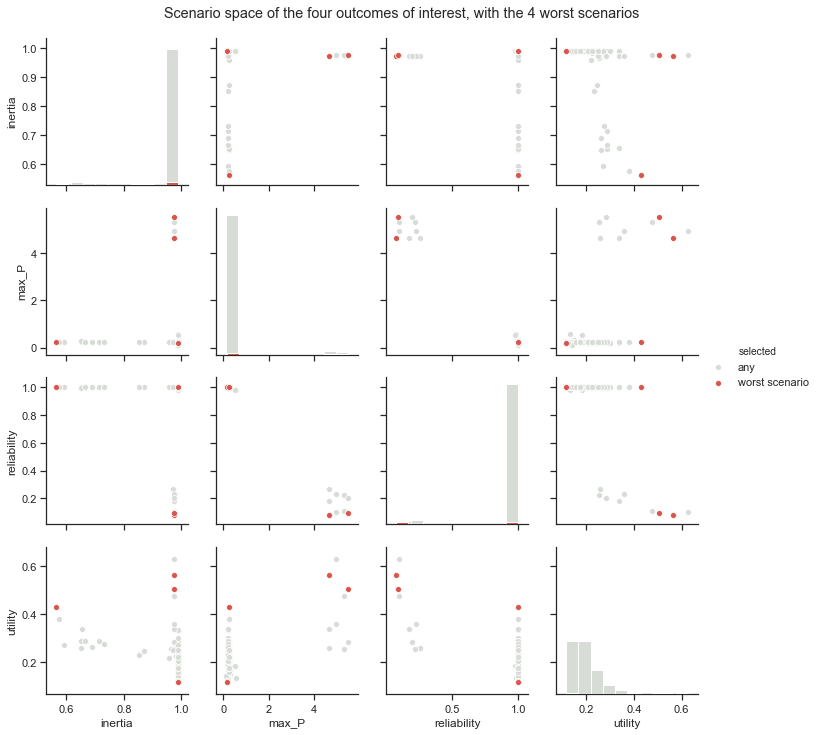

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker  

import seaborn as sns
import itertools

sns.set(style="ticks", color_codes=True)    
sns.axes_style('white')
colors = ["light grey",  "pale red"]

for entry, name in zip(np.unique(sel_column), ['any', 'worst scenario']):
    data.replace(entry, name, inplace=True)
    
g = sns.pairplot(data, hue='selected', 
                 diag_kind='hist',
                 markers = ['o', 'o'],
             palette= sns.xkcd_palette(colors), vars = oois)

plt.suptitle("Scenario space of the four outcomes of interest, with the 4 worst scenarios", y=1.02)

# tag_indices = {0: 'inertia', 1: 'max_P', 2: 'reliability', 3: 'utility'}   

# g.savefig('./figs/mordm/scatter_diverse_random_prim.png', dpi=600)
plt.show()

Change the selected scenarios into a list for further input

In [10]:
selected_scenarios = []

from ema_workbench import Scenario

for index, row in newExperiments.iterrows():
        selected_scenarios.append(Scenario(str(index), ** row.to_dict()))

In [11]:
selected_scenarios

[Scenario({'b': 0.31039691586767404, 'delta': 0.9302445719808624, 'mean': 0.04339412909896332, 'q': 3.2084215221292545, 'stdev': 0.0022655988976392548, 'scenario': 361}),
 Scenario({'b': 0.2443220818290535, 'delta': 0.9388848089448182, 'mean': 0.045192811086455835, 'q': 3.0255899661065238, 'stdev': 0.002592541206950032, 'scenario': 615}),
 Scenario({'b': 0.20751446556446013, 'delta': 0.9328195118553152, 'mean': 0.0454138578693274, 'q': 4.031903116868822, 'stdev': 0.00428970381579591, 'scenario': 911}),
 Scenario({'b': 0.3226324536482249, 'delta': 0.9519506956562386, 'mean': 0.02685628260134967, 'q': 4.1197571778242486, 'stdev': 0.002729276062659265, 'scenario': 960})]

## Search for each scenario

For each of the four selected scenarios, use many-objective optimization to find a pareto approximate set using the same approach as for assignment 8. Remember to check for convergence (and time permitting, seed analysis), and be careful in what epsilon values to use (not to coarse, not too small). 

Store the resulting set of pareto solutions in a smart way for subsequent analysis.


### Searching solutions

In [12]:
from dps_lake_model import lake_model

from ema_workbench import (Model, RealParameter, ScalarOutcome,
                           MultiprocessingEvaluator, ema_logging,
                           Constant)

ema_logging.log_to_stderr(ema_logging.INFO)

#instantiate the model
lake_model = Model('lakeproblem', function=lake_model)
lake_model.time_horizon = 100 # used to specify the number of timesteps

#specify uncertainties
lake_model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('delta', 0.93, 0.99)]

# set levers, one for each time step
lake_model.levers = [RealParameter('c1', -2, 2),
                     RealParameter('c2', -2, 2),
                     RealParameter('r1', 0, 2),
                     RealParameter('r2', 0, 2),
                     RealParameter('w1', 0, 1)]

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE),
                       ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE),
                       ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE),
                       ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE)]

lake_model.constants = [Constant('alpha', 0.4),
                            Constant('nsamples', 100),
                            Constant('myears', 100)]

In [13]:
from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)
from ema_workbench import Constraint

lake_model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE,
                                     expected_range=(0,5)),
                       ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,2)),
                       ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE,
                                    expected_range=(0,1)),
                       ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,1))]

convergence_metrics = [HyperVolume.from_outcomes(lake_model.outcomes),
                       EpsilonProgress()]

##### Senario 1

In [14]:
with MultiprocessingEvaluator(lake_model) as evaluator:
    results_1, convergence_1 = evaluator.optimize(nfe=10000, searchover='levers', 
                                   reference = selected_scenarios[0],
                                   epsilons=[0.01, 0.01, 0.01,0.01],
                                   convergence=convergence_metrics)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] generation 5: 496/10000 nfe
[MainProcess/INFO] generation 10: 990/10000 nfe
[MainProcess/INFO] generation 15: 1487/10000 nfe
[MainProcess/INFO] generation 20: 1979/10000 nfe
[MainProcess/INFO] generation 25: 2476/10000 nfe
[MainProcess/INFO] generation 30: 2975/10000 nfe
[MainProcess/INFO] generation 35: 3467/10000 nfe
[MainProcess/INFO] generation 40: 3962/10000 nfe
[MainProcess/INFO] generation 45: 4451/10000 nfe
[MainProcess/INFO] generation 50: 4947/10000 nfe
[MainProcess/INFO] generation 55: 5438/10000 nfe
[MainProcess/INFO] generation 60: 5935/10000 nfe
[MainProcess/INFO] generation 65: 6428/10000 nfe
[MainProcess/INFO] generation 70: 6919/10000 nfe
[MainProcess/INFO] generation 75: 7418/10000 nfe
[MainProcess/INFO] generation 80: 7916/10000 nfe
[MainProcess/INFO] generation 85: 8415/10000 nfe
[MainProcess/INFO] generation 90: 8908/10000 nfe
[MainProcess/INFO] generation 95: 9398/10000

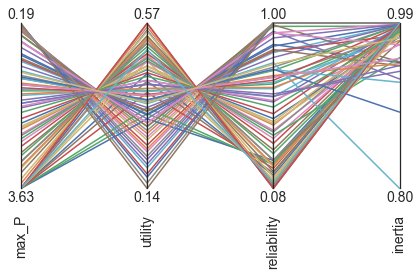

In [15]:
import matplotlib.pyplot as plt
from ema_workbench.analysis import parcoords

outcomes_1 = results_1.loc[:, ['max_P', 'utility', 'reliability', 'inertia']]

limits = parcoords.get_limits(outcomes_1)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes_1)

# we invert this axis so direction of desirability is the same 
axes.invert_axis('max_P') 
plt.show()

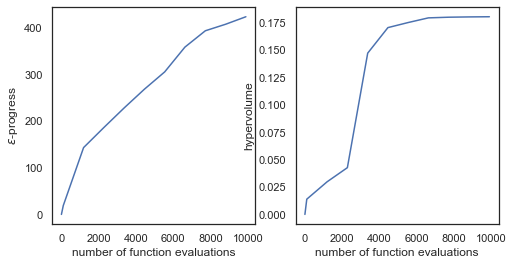

In [16]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence_1.nfe, convergence_1.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence_1.nfe, convergence_1.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

Hypervolumn shows the indication of covergency

##### Senario 2

In last experiments, too many solutions were found out. Thus, in this block, I decided to increase the epsilon a little bit

In [17]:
with MultiprocessingEvaluator(lake_model) as evaluator:
    results_2, convergence_2 = evaluator.optimize(nfe=10000, searchover='levers', 
                                   reference = selected_scenarios[1],
                                   epsilons=[0.05, 0.05, 0.05,0.05],
                                   convergence=convergence_metrics)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] generation 5: 494/10000 nfe
[MainProcess/INFO] generation 10: 988/10000 nfe
[MainProcess/INFO] generation 15: 1485/10000 nfe
[MainProcess/INFO] generation 20: 1985/10000 nfe
[MainProcess/INFO] generation 25: 2484/10000 nfe
[MainProcess/INFO] generation 30: 2978/10000 nfe
[MainProcess/INFO] generation 35: 3472/10000 nfe
[MainProcess/INFO] generation 40: 3966/10000 nfe
[MainProcess/INFO] generation 45: 4462/10000 nfe
[MainProcess/INFO] generation 50: 4957/10000 nfe
[MainProcess/INFO] generation 55: 5454/10000 nfe
[MainProcess/INFO] generation 60: 5945/10000 nfe
[MainProcess/INFO] generation 65: 6437/10000 nfe
[MainProcess/INFO] generation 70: 6935/10000 nfe
[MainProcess/INFO] generation 75: 7432/10000 nfe
[MainProcess/INFO] generation 80: 7927/10000 nfe
[MainProcess/INFO] generation 85: 8421/10000 nfe
[MainProcess/INFO] generation 90: 8914/10000 nfe
[MainProcess/INFO] generation 95: 9408/10000

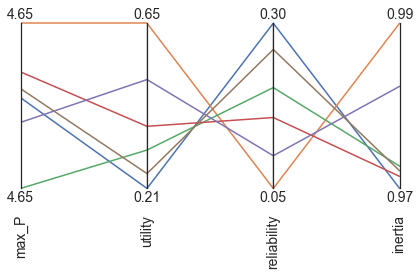

In [18]:
import matplotlib.pyplot as plt
from ema_workbench.analysis import parcoords

outcomes_2 = results_2.loc[:, ['max_P', 'utility', 'reliability', 'inertia']]

limits = parcoords.get_limits(outcomes_2)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes_2)

# we invert this axis so direction of desirability is the same 
axes.invert_axis('max_P') 
plt.show()

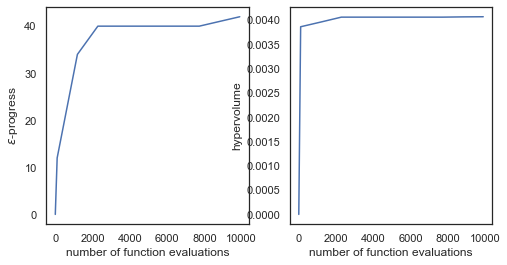

In [19]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence_2.nfe, convergence_2.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence_2.nfe, convergence_2.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

##### Scenario = 3

In [20]:
with MultiprocessingEvaluator(lake_model) as evaluator:
    results_3, convergence_3 = evaluator.optimize(nfe=10000, searchover='levers', 
                                   reference = selected_scenarios[2],
                                   epsilons=[0.05, 0.05, 0.05,0.05],
                                   convergence=convergence_metrics)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] generation 5: 496/10000 nfe
[MainProcess/INFO] generation 10: 991/10000 nfe
[MainProcess/INFO] generation 15: 1488/10000 nfe
[MainProcess/INFO] generation 20: 1984/10000 nfe
[MainProcess/INFO] generation 25: 2477/10000 nfe
[MainProcess/INFO] generation 30: 2969/10000 nfe
[MainProcess/INFO] generation 35: 3468/10000 nfe
[MainProcess/INFO] generation 40: 3965/10000 nfe
[MainProcess/INFO] generation 45: 4460/10000 nfe
[MainProcess/INFO] generation 50: 4951/10000 nfe
[MainProcess/INFO] generation 55: 5450/10000 nfe
[MainProcess/INFO] generation 60: 5944/10000 nfe
[MainProcess/INFO] generation 65: 6441/10000 nfe
[MainProcess/INFO] generation 70: 6939/10000 nfe
[MainProcess/INFO] generation 75: 7436/10000 nfe
[MainProcess/INFO] generation 80: 7934/10000 nfe
[MainProcess/INFO] generation 85: 8426/10000 nfe
[MainProcess/INFO] generation 90: 8921/10000 nfe
[MainProcess/INFO] generation 95: 9416/10000

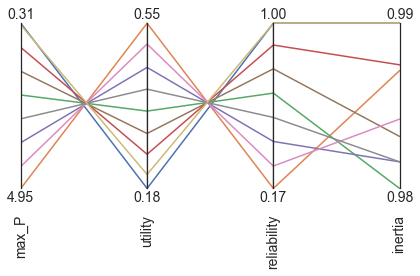

In [21]:
import matplotlib.pyplot as plt
from ema_workbench.analysis import parcoords

outcomes_3 = results_3.loc[:, ['max_P', 'utility', 'reliability', 'inertia']]

limits = parcoords.get_limits(outcomes_3)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes_3)

# we invert this axis so direction of desirability is the same 
axes.invert_axis('max_P') 
plt.show()

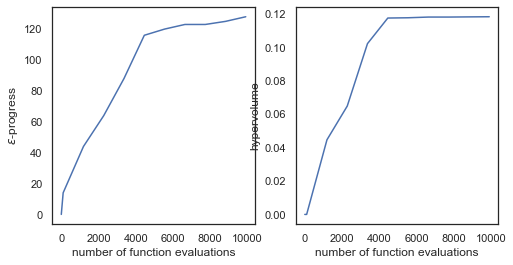

In [22]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence_3.nfe, convergence_3.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence_3.nfe, convergence_3.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

##### Scenario =  4

In [23]:
with MultiprocessingEvaluator(lake_model) as evaluator:
    results_4, convergence_4 = evaluator.optimize(nfe=10000, searchover='levers', 
                                   reference = selected_scenarios[3],
                                   epsilons=[0.05, 0.05, 0.05,0.05],
                                   convergence=convergence_metrics)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] generation 5: 492/10000 nfe
[MainProcess/INFO] generation 10: 986/10000 nfe
[MainProcess/INFO] generation 15: 1485/10000 nfe
[MainProcess/INFO] generation 20: 1982/10000 nfe
[MainProcess/INFO] generation 25: 2476/10000 nfe
[MainProcess/INFO] generation 30: 2973/10000 nfe
[MainProcess/INFO] generation 35: 3466/10000 nfe
[MainProcess/INFO] generation 40: 3961/10000 nfe
[MainProcess/INFO] generation 45: 4458/10000 nfe
[MainProcess/INFO] generation 50: 4954/10000 nfe
[MainProcess/INFO] generation 55: 5444/10000 nfe
[MainProcess/INFO] generation 60: 5940/10000 nfe
[MainProcess/INFO] generation 65: 6435/10000 nfe
[MainProcess/INFO] generation 70: 6927/10000 nfe
[MainProcess/INFO] generation 75: 7421/10000 nfe
[MainProcess/INFO] generation 80: 7918/10000 nfe
[MainProcess/INFO] generation 85: 8408/10000 nfe
[MainProcess/INFO] generation 90: 8904/10000 nfe
[MainProcess/INFO] generation 95: 9401/10000

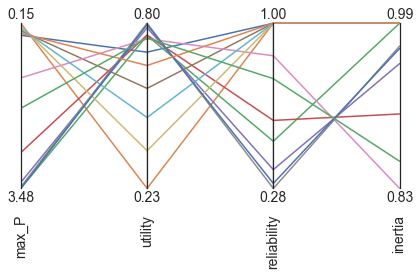

In [24]:
import matplotlib.pyplot as plt
from ema_workbench.analysis import parcoords

outcomes_4 = results_4.loc[:, ['max_P', 'utility', 'reliability', 'inertia']]

limits = parcoords.get_limits(outcomes_4)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes_4)

# we invert this axis so direction of desirability is the same 
axes.invert_axis('max_P') 
plt.show()

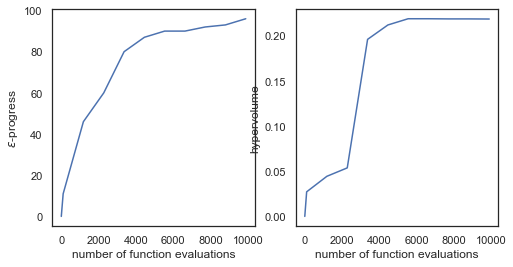

In [25]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence_4.nfe, convergence_4.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence_4.nfe, convergence_4.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

## Re-evaluate under deep uncertainty

Combine the pareto set of solutions found for each scenario. Next, turn each solution into a policy object. If you have a very large number of policies, you can choose to down sample your policies in some reasoned way (*e.g.*, picking min and max on each objective, slicing across the pareto front with a particular step size). As a rule of thumb, try to limit the set of policies to at most 50. 

Re-evaluate the combined set of solutions over 1000 scenarios sampled using LHS.


###### Select policies first

In [26]:
#Scenario 1 contains too many policies, thus the polices are selecte by the min and max values of each objective. 
# Inertia is excluded as it has serveral min/max values
selected_policy_1 = [np.argmax(results_1['max_P']), np.argmax(results_1['reliability']),
             np.argmax(results_1['utility']),np.argmin(results_1['max_P']),
             np.argmin(results_1['reliability']), np.argmin(results_1['utility'])]

selected_policy = results_1.iloc[selected_policy_1]

C:\Users\teres\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
C:\Users\teres\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


In [27]:
selected_policy = selected_policy.drop_duplicates()

In [28]:
selected_policy 

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
79,0.519261,-0.392519,0.422421,1.914176,0.132477,3.634175,0.503533,0.99,0.1127
3,0.309768,0.377228,0.260045,0.813818,0.195305,0.214925,0.175592,0.99,1.0000
5,0.959072,0.283125,1.900961,0.037131,0.119613,3.633315,0.573017,0.99,0.0800
75,0.410173,0.198190,1.098143,0.153753,0.176500,0.187496,0.137289,0.99,1.0000


In [29]:
# Combine all the polices from the four scenarios
policies = pd.concat([selected_policy, results_2, results_3, results_4], axis=0, ignore_index=True)

In [30]:
policies

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
0,0.519261,-0.392519,0.422421,1.914176,0.132477,3.634175,0.503533,0.9900,0.1127
1,0.309768,0.377228,0.260045,0.813818,0.195305,0.214925,0.175592,0.9900,1.0000
2,0.959072,0.283125,1.900961,0.037131,0.119613,3.633315,0.573017,0.9900,0.0800
3,0.410173,0.198190,1.098143,0.153753,0.176500,0.187496,0.137289,0.9900,1.0000
4,0.341033,0.322046,1.370356,0.694305,0.031149,4.649048,0.214837,0.9722,0.3028
5,0.447473,-1.036105,1.232346,1.845393,0.224602,4.648615,0.653307,0.9900,0.0500
6,0.009044,0.452273,1.196160,0.700621,0.470243,4.649574,0.316671,0.9746,0.2043
7,0.971117,0.239176,1.370356,0.797955,0.168749,4.648898,0.379657,0.9735,0.1585
8,0.490203,-0.547787,0.991464,1.940685,0.586839,4.649190,0.503783,0.9832,0.1000
9,0.009044,0.431631,1.338645,0.700621,0.474457,4.648995,0.254156,0.9741,0.2626


In [31]:
from ema_workbench import Policy
policies_input = []

for index, row in policies.iterrows():
        policies_input.append(Policy(str(index), ** row.to_dict()))

##### Re-evaluate the policies

In [32]:
with  MultiprocessingEvaluator(lake_model) as evaluator:
    results = evaluator.perform_experiments(scenarios = 1000,
                                            policies = policies_input)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 32 policies * 1 model(s) = 32000 experiments
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 6400 cases completed
[MainProcess/INFO] 9600 cases completed
[MainProcess/INFO] 12800 cases completed
[MainProcess/INFO] 16000 cases completed
[MainProcess/INFO] 19200 cases completed
[MainProcess/INFO] 22400 cases completed
[MainProcess/INFO] 25600 cases completed
[MainProcess/INFO] 28800 cases completed
[MainProcess/INFO] 32000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [46]:
experiments, outcomes = results

In [49]:
df_outcomes=pd.DataFrame(outcomes)

Calculate both the maximum regret, and the domain criterion using the values provided in [Bartholomew and Kwakkel (2020)](https://doi.org/10.1016/j.envsoft.2020.104699). Ignore the max_P objective.

visualize the results in parallel coordinate plot. 

Are there any promising compromise solutions which balance performance in both the reference scenarios as well as in terms of their robustness?


##### Calculate maximum regret

In [54]:
def best(data, type = 'maximize'):
    if type == 'maximize':
        best =  np.max(data)
    else:
        best = np.min(data)
    return best

In [71]:
sn_reliability = outcomes['reliability'] # Maximize
sn_utility = outcomes['utility'] # Maximize
sn_maxP = outcomes['max_P'] # Minimize
sn_inertia = outcomes['inertia'] # Maximize

experiments = experiments.sort_values(['scenario'])
experiments_mr = experiments.loc[:,['scenario','policy']]
experiments_mr['reliability'] = sn_reliability
experiments_mr['max_P'] = sn_maxP
experiments_mr['inertia'] = sn_inertia
experiments_mr['utility'] = sn_utility

best_all_dic =  {}
for scenario in  np.unique(experiments['scenario']):
    best_dic = {}
    best_dic['best_reliabilty'] =  best(experiments_mr[experiments_mr['scenario'] == scenario]['reliability'])
    best_dic['best_maxP'] =  best(experiments_mr[experiments_mr['scenario'] == scenario]['max_P'], type = 'minimize')
    best_dic['best_inertia'] = best(experiments_mr[experiments_mr['scenario'] == scenario]['inertia'])
    best_dic['best_utility'] = best(experiments_mr[experiments_mr['scenario'] == scenario]['utility'])
    best_all_dic[scenario] = best_dic
mr_df = pd.DataFrame.from_dict(best_all_dic).T

mr_df = mr_df.reset_index()

data = pd.merge(experiments_mr,mr_df, left_on='scenario',right_on='index')

data['regret_reliability'] = (data['best_reliabilty'] - data['reliability']).abs()
data['regret_maxP'] = (data['best_maxP'] - data['max_P']).abs()
data['regret_inertia'] = (data['best_inertia'] - data['inertia']).abs()
data['regret_utility'] = (data['best_utility'] - data['utility']).abs()

regret = data.groupby('policy').sum()

regret = regret.loc[:,['regret_reliability','regret_maxP','regret_inertia','regret_utility']]

In [79]:
regret.head()

,regret_reliability,regret_maxP,regret_inertia,regret_utility
policy,,,,
0,478.7588,2929.451883,54.2257,1295.969406
1,509.2980,3110.996783,51.9014,1283.966889
10,511.3708,3138.258959,51.9177,1290.474824
11,519.3741,3158.750014,48.2739,1270.865216
12,487.6038,3046.130056,52.6376,1311.388342


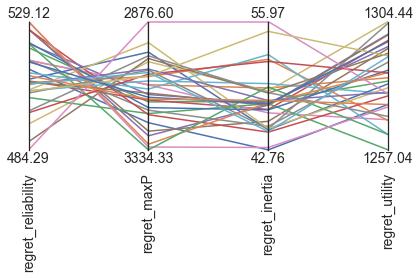

In [65]:
import matplotlib.pyplot as plt
from ema_workbench.analysis import parcoords

limits = parcoords.get_limits(regret)
axes = parcoords.ParallelAxes(limits)
axes.plot(regret)

# we invert this axis so direction of desirability is the same 
axes.invert_axis('regret_maxP') 
plt.show()

In [82]:
regret_new = regret.reset_index()

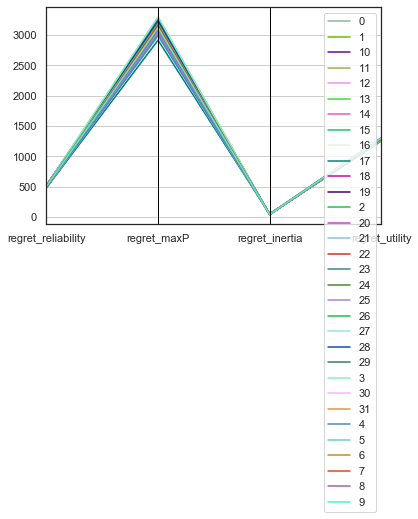

In [84]:
plt.figure()
pd.plotting.parallel_coordinates(regret_new, 'policy')

policy = 9 is the most robust policy according to maximum regret